# Tracking of Lorenz 63 system with particle filtering

In this Python notebook, we will quickly sketch how you can implement a PF for tracking Lorenz 63 model.

## Simulation of Lorenz 63 model

In this part, we start with simulating some data from our system, hereby setting the problem setup. The system of interest we would like to estimate is given by a three-dimensional stochastic differential equation,

\begin{align*}
\mbox{d}x_1 &= - \mathsf{s}(x_1 - x_2) + \mbox{d} w_1, \\
\mbox{d} x_2 &= \mathsf{r}x_1 - x_2 - x_1 x_3 + \mbox{d} w_2, \\
\mbox{d} x_3 &= x_1 x_2 - \mathsf{b}x_3 + \mbox{d} w_3,
\end{align*}


where $\{w_i(s)\}_{s\in(0,\infty)}$ are 1-dimensional independent Wiener processes and $\mathsf{s},\mathsf{r},\mathsf{b} \in \mathbb{R}$ are parameters. In order to simulate it, we would like to discretise this system via an Euler-Maruyama scheme and obtain the following recursive equations,

\begin{align*}
x_{1,t} &= x_{1,t-1} - \mathsf{T} \mathsf{s} (x_{1,t-1} - x_{2,t-1}) + \sqrt{\mathsf{T}} u_{1,t} \\
x_{2,t} &= x_{2,t-1} + \mathsf{T} (\mathsf{r} x_{1,t-1} - x_{2,t-1} - x_{1,t-1} x_{3,t-1}) + \sqrt{\mathsf{T}} u_{2,t} \\
x_{3,t} &= x_{3,t-1} + \mathsf{T} (x_{1,t-1} x_{2,t-1} - \mathsf{b}x_{3,t-1}) + \sqrt{\mathsf{T}} u_{3,t}
\end{align*}

Furthermore, we will assume that the observations are collected with a certain period, $t_s$, so not every time step is observable to us. Therefore, if total time is given by $TT$ (as below), the number of observations will be given by $n = TT / t_s$. Let's generate the state variables and observations.

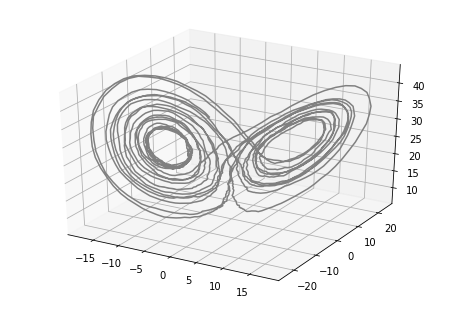

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Simulate Lorenz 63 system

s = 10
r = 28
b = 8.0 / 3.0

TT = 20000
ts = 10

n = int(TT / ts)

X = np.zeros([3,TT])
Xn = np.zeros([3,n])
Y = np.zeros([n])

T = 1e-3

X[:,[0]] = [[-5.91],[-5.52],[24.57]]
k = 0
k_o = 0.8
q = 1

for t in range(1,TT):
    
    X[0,t] = X[0,t-1] - T * s * (X[0,t-1] - X[1,t-1]) + np.sqrt(T) * np.random.normal(0,1)
    X[1,t] = X[1,t-1] + T * (r*X[0,t-1] - X[1,t-1] - X[0,t-1] * X[2,t-1]) + np.sqrt(T) * np.random.normal(0,1)
    X[2,t] = X[2,t-1] + T * (X[0,t-1] * X[1,t-1] - b * X[2,t-1]) + np.sqrt(T) * np.random.normal(0,1)
    
    if (t-1) % ts == 0:
        Xn[:,[k]] = X[:,[t]]
        Y[k] = k_o * Xn[0,k] + np.sqrt(q) * np.random.normal(0,1) 
        k = k + 1

# Let us plot the 3D system we have simulated:
Fig1 = plt.figure(1)
ax = Axes3D(Fig1)
ax.plot3D(Xn[0,:],Xn[1,:],Xn[2,:],'gray')

As you can see from the plot, the system is a 3D stochastic dynamical system with chaotic trajectories. Now, as we have said, we assume that we observe only the first dimension (and at every $t_s$ steps). We generate the observations as follows,

\begin{align*}
y_n = k_o x_{1,n t_s} + v_n, \quad n = 1, 2, ...,
\end{align*}

with $v_n \sim \mathcal{N}(0,q)$. Here is what observation sequence looks like:

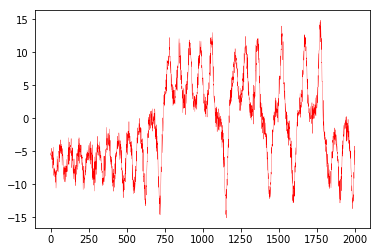

In [2]:
Fig2 = plt.figure(2)
plt.plot(Y,'r-',linewidth = 0.3)

## Particle filtering for Lorenz 63 model

Now, we can move on to particle filtering. First we define a resampling function to resample from a weighted distribution with multivariate particles.

In [3]:
# Particle filtering

def resample(Xp,w):
    # Resampling for multivariate particles
    N = int(Xp.shape[1])
    
    resInd = np.random.choice(np.array(range(N)),N,replace=True,p=w)
    XpR = np.zeros(Xp.shape)
    for k in range(0,N):
        XpR[:,[k]] = Xp[:,[resInd[k]]]
    return XpR

Then we set parameters and off we go. You can find the explanation of the particle filtering [here](http://www.almoststochastic.com/2013/08/sequential-importance-sampling.html), a primer on filtering [here](http://www.almoststochastic.com/2016/10/a-primer-on-filtering.html), and a notebook implementation [here](https://github.com/odakyildiz/ipython/blob/master/PF1D.ipynb). Note that, here in the simulation step, we simulate forward particles $t_s$ times, as we get observations only every $t_s$ step.

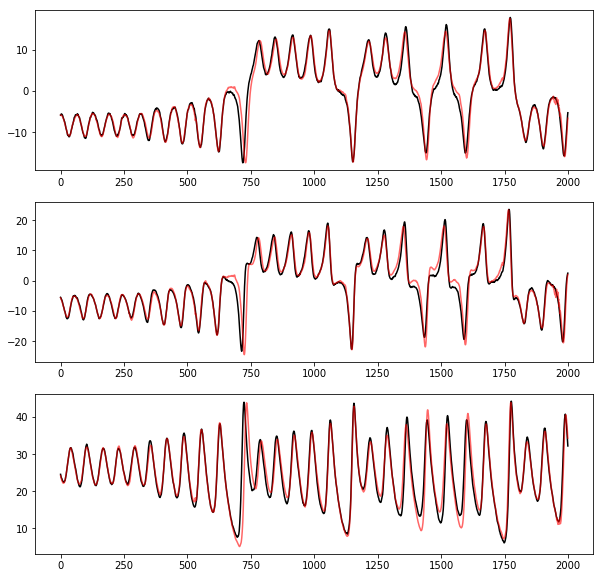

In [5]:
N = 100

Xp = np.random.normal(0,0.01,[3,N]) + Xn[:,[0]]# Initialize the particle system
XpN = np.zeros([3,N])
Xest = np.zeros([3,n])
logW = np.zeros([N])

for t in range(0,n):
    
    for m in range(0,ts):
        for k in range(0,N):
            XpOld = Xp
            Xp[0,k] = XpOld[0,k] - T * s * (XpOld[0,k] - XpOld[1,k]) + np.sqrt(T) * np.random.normal(0,1)
            Xp[1,k] = XpOld[1,k] + T * (r*XpOld[0,k] - XpOld[1,k] - XpOld[0,k] * XpOld[2,k]) + np.sqrt(T) * np.random.normal(0,1)
            Xp[2,k] = XpOld[2,k] + T * (XpOld[0,k] * XpOld[1,k] - b * XpOld[2,k]) + np.sqrt(T) * np.random.normal(0,1)
            
    for k in range(0,N):
        logW[k] = -0.5 * (1/(2*q)) * np.power((Y[t] - k_o * Xp[0,k]),2)
    
    W = np.exp(logW - np.max(logW))
    
    w = np.divide(W,np.sum(W))
    
    for k in range(0,N):
        Xest[:,[t]] = Xest[:,[t]] + w[k] * Xp[:,[k]]
    
    Xp = resample(Xp,w)

Fig3 = plt.figure(3,figsize=(10,10))
plt.subplot(311)
plt.plot(Xn[0,:],'k')
plt.plot(Xest[0,:],'r',alpha=0.6)
plt.subplot(312)
plt.plot(Xn[1,:],'k')
plt.plot(Xest[1,:],'r',alpha=0.6)
plt.subplot(313)
plt.plot(Xn[2,:],'k')
plt.plot(Xest[2,:],'r',alpha=0.6)

Black signals are original signals and red signals are estimates (instead of scattering 3D, we plotted all dimensions separately). Seems like it's working!